<a href="https://colab.research.google.com/github/DrAlexSanz/examples/blob/main/Cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code from [Keras example cat vs dog](https://keras.io/examples/vision/image_classification_from_scratch/)

Goal: Learn the library

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install pydot

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  92.8M      0  0:00:08  0:00:08 --:--:-- 97.2M


In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [4]:
!ls PetImages

Cat  Dog


# Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [5]:
import os

num_skipped = 0

for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


# Generate Dataset

In [37]:
img_size = (180, 180)

batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory = "PetImages",
                                                               labels = "inferred",
                                                               validation_split = 0.2,
                                                               subset = "training",
                                                               seed = 1337,
                                                               image_size = img_size,
                                                               batch_size = batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(directory = "PetImages",
                                                              labels = "inferred",
                                                              validation_split = 0.2,
                                                              subset = "validation",
                                                              seed = 1337,
                                                              image_size = img_size,
                                                              batch_size = batch_size)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


# Visualize data

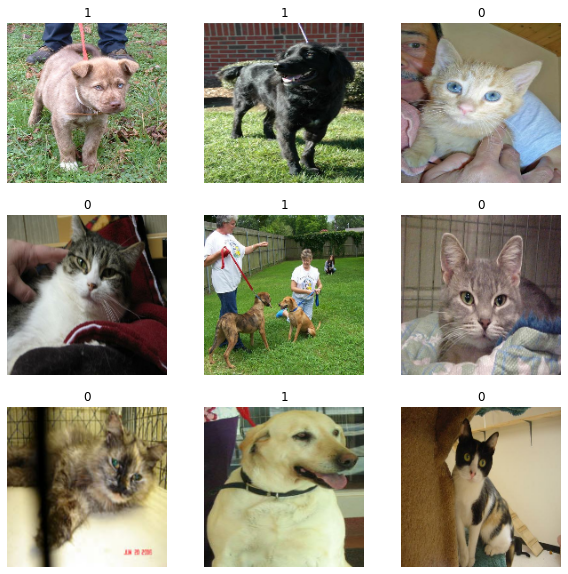

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
# Optimize performance

train_ds = train_ds.prefetch(buffer_size = 32)
test_ds = test_ds.prefetch(buffer_size = 32)

# Preprocess the images


1.   As a layer at the beginning of the network --> Use the GPU
2.   Applying it to the dataset --> Less efficient unless training is on CPU
3. Preprocess the images once. Maybe not great here.

This applies to data augmentation and rescaling.



In [9]:
data_augmentation = keras.Sequential(
    [
     layers.RandomFlip(mode = "horizontal"),
     layers.RandomRotation(factor = 0.1)
    ]    
                                    )

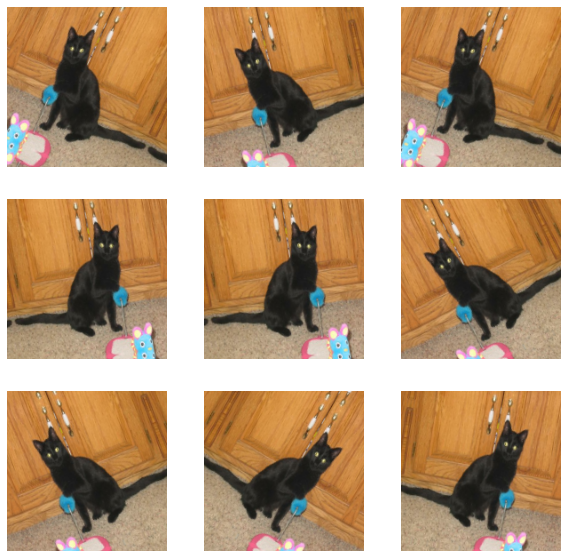

In [45]:
plt.figure(figsize = (10, 10))

for images, _ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_images = data_augmentation(images)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
          plt.axis("off")

# Build the model

It's an Xception net

In [59]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)



In [54]:
a =  (180, 180) + (3,)
print(a)

(180, 180, 3)


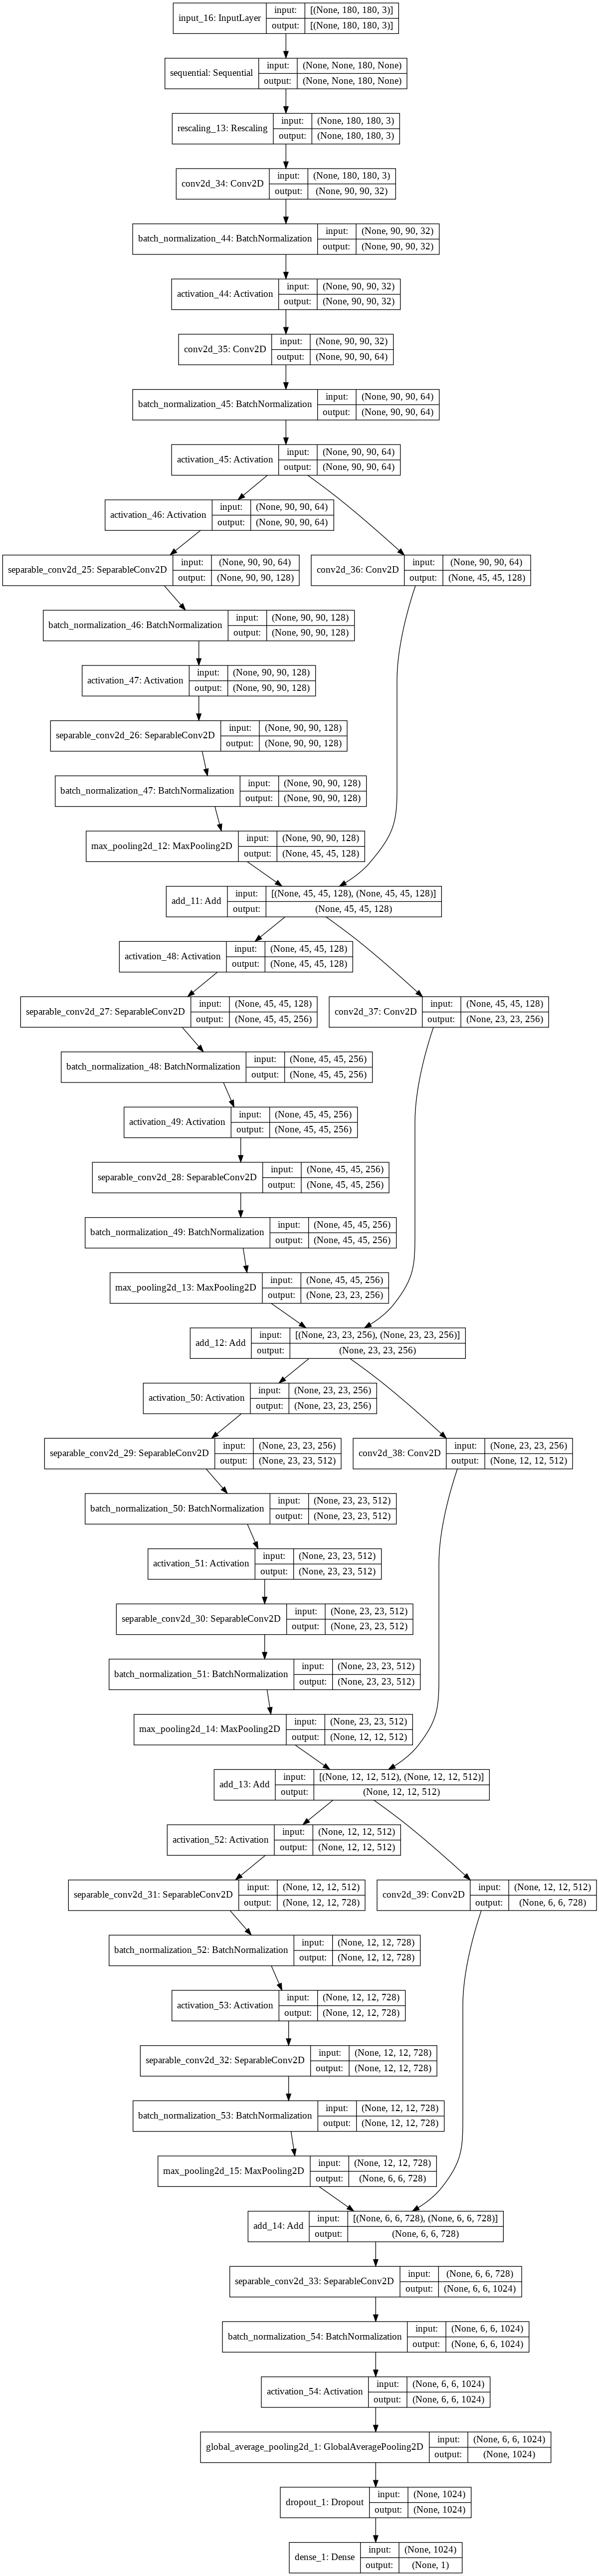

In [61]:
model = make_model(input_shape = img_size + (3,), num_classes = 2)

keras.utils.plot_model(model = model, show_shapes = True)

## Train the model

In [62]:
epochs = 50

callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),]

model.compile(optimizer = keras.optimizers.Adam(1e-3),
              loss = "binary_crossentropy",
              metrics = ["accuracy"],)

model.fit(train_ds, epochs = epochs, callbacks = callbacks, validation_data = val_ds)